In [25]:
from os_utilities import make_folder

from orb_builder import *
import soap_utilities as su
import report_parser as rp
import slice_analysis_nx as sanx # network x based
import slice_analysis as sagt # graph-tools based
from distances_tvg import *
from matrix import *
from ml_knn import *

from tqdm import tqdm
from datetime import datetime
import itertools

import networkx as nx


In [26]:
folder_base = f"./outputs/experiments"
make_folder(folder_base)

starlink = build_satellites_csv("starlink")
moon_sats = get_moon_platforms()
mars_sats = get_mars_platforms()
ground = [
    create_ground_object_dictionary("Ground-Albany", 42.685012663456163, -73.82479012295363, 0),
    create_ground_object_dictionary("Ground-Sydney", -33.868888888888889, 151.20939697339508, 0)
]
norad = build_satellites_from_tle("./sources/tdrss.tle")

def generate_orb_files(folder_name, name, satellites, date):
        save_to_outputs_file(
                generate_orb(satellites, name, date),
                f"experiments/{folder_name}/{name}", "orb")
        return name + ".orb"

In [27]:
n = 50

date = datetime.now()
print(f"Running Lifetime Matrix Simulations on Date = {date}")

folder_name = f"starlink-{n}-sat-single"
make_folder(f"{folder_base}/{folder_name}")

print(f"Generating ORB File")

name = f"starlink_{date.strftime('%Y-%m')}"
orb_filename = generate_orb_files(
    folder_name, 
    name, 
    sample_sats(starlink, n),
    date)
            
orb_path = f"{folder_base}/{folder_name}/{orb_filename}"

print("Running SOAP on ORB file")
# su.run_soap_mac([orb_path], max_workers=10)

Running Lifetime Matrix Simulations on Date = 2023-04-21 13:28:04.813650
Generating ORB File
Running SOAP on ORB file


In [28]:
print(f"Constructing Matrices from ORB Files")

filepath = orb_path.replace(".orb", " Contact Analysis.csv")

matrix = rp.soap_converter(filepath)
# A = matrix.thicken_matrix(1)
A = matrix
B = IntervalMatrix.complete_matrix(matrix.dim_row)
m = matrix.dim_row

# matrix_raw_sym = [
#     [P.open(0,20), P.closed(0, 6), P.closed(6, 10), P.empty()],
#     [P.closed(0, 6), P.open(0, 20), P.closed(1, 4), P.closed(3, 7)],
#     [P.closed(6, 10), P.closed(1, 4), P.open(0, 20), P.closed(0, 8)],
#     [P.empty(), P.closed(3, 7), P.closed(0, 8), P.open(0, 20)]
# ]
# # matrix = IntervalMatrix(4, 4, matrix_raw)
# matrix = IntervalMatrix(4, 4, matrix_raw_sym)
# m = matrix.dim_row
# A = matrix

print(f"A is a {m}x{m} Matrix")



Constructing Matrices from ORB Files
A is a 48x48 Matrix


In [34]:
print(f"Calculating Walks")

start_time, end_time = 0, 86400
walk_length = 10

walks = [IntervalMatrix.identity_matrix(m)]

print(f"Calculating Walks a {n}-Satellite System")
for k in range(1, walk_length):
    print(f"  Calculating {k}-Walks for a {n}-Sat system")
    print(f"len of walks = {len(walks)}")
    if k == 1:
        A_k = A
    else:
        A_k = A * walks[-1]

    # print(f"    A^{k}[0][2]={A_k[0, 2]}")
    # print(A_k)

    walks.append(A_k)

Calculating Walks
Calculating Walks a 50-Satellite System
  Calculating 1-Walks for a 50-Sat system
len of walks = 1
  Calculating 2-Walks for a 50-Sat system
len of walks = 2
  Calculating 3-Walks for a 50-Sat system
len of walks = 3
  Calculating 4-Walks for a 50-Sat system
len of walks = 4
  Calculating 5-Walks for a 50-Sat system
len of walks = 5
  Calculating 6-Walks for a 50-Sat system
len of walks = 6
  Calculating 7-Walks for a 50-Sat system
len of walks = 7
  Calculating 8-Walks for a 50-Sat system
len of walks = 8
  Calculating 9-Walks for a 50-Sat system
len of walks = 9


In [35]:
# Calculating Distances
print(f"Calculating Lifetime Matrix")

# Lifetime Matrix
L = tvg_lifetime_matrix(walks, start_time, end_time, walk_length)

y_list = generate_y_list(L, m, walk_length)
y_list_average = calculate_y_list_average(y_list, walk_length)
lifetime_list = y_list_average
print(lifetime_list)

Calculating Lifetime Matrix
[0.0, 0.0, 11122.8728430851, 63104.5898147164, 80948.33457269512, 85624.21189893608, 86179.84734308516, 86259.68729787227, 86268.66082978719, 86268.66082978719]


Plotting Lifetime Curve


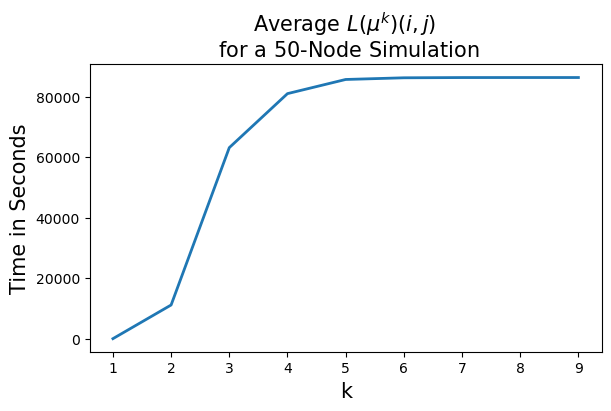

In [36]:
# Plot Lifetime Distances and Confidence Intervals
print(f"Plotting Lifetime Curve")

x = list(range(1, walk_length))

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 4))

axs.set_title(f"Average $L(\mu^k)(i, j)$ \n for a ${n}$-Node Simulation", fontsize=15)
axs.plot(x, lifetime_list[1:], linewidth=2)

axs.set_xlabel("k", fontsize=15)
axs.set_ylabel("Time in Seconds", fontsize=15)

# Hide x labels and tick labels for top plots and y ticks for right plots.
axs.label_outer()

plt.savefig(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.png")
plt.show()

In [32]:
# Slice Analysis
print(f"Calculating Slice Analysis")

filepath = orb_path.replace(".orb", " Contact Analysis.csv")

contact_plan = rp.contact_analysis_parser(filepath)
tvg = rp.construct_graph(contact_plan, delta = 1)
# critical_times[i][j] = rp.extract_critical_times(graph)
critical_times = rp.extract_critical_times(tvg)
sample_times = rp.sample_critical_times(critical_times)

print(f"Number of Critical Times {len(critical_times)}")

disconnected_counter = 0
diameters = []

for k, time in enumerate(sample_times):
    graph = sanx.get_graph_slice_at(tvg, time)
    print(f"{k} : time={time}")

    diameter = -1
    for sg in [graph.subgraph(c).copy() for c in nx.connected_components(graph)]:
        diameter = max(diameter, nx.diameter(sg))
        periphery = nx.periphery(sg)
        # print(f"Periphery has length {len(periphery)}")
        if len(periphery) > 1:
            n1 = periphery[0]
            n2 = periphery[1]
            diameter_nodes = nx.shortest_path(sg, source = n1, target = n2)
            # print(diameter_nodes)
            print(f"  Diameter={nx.diameter(sg)}; len(periphery)={len(periphery)}, path={diameter_nodes}")
        else:
            print("  Periphery has only one element.")

    if nx.number_connected_components(graph) > 1:
        print(f"  slice has {nx.number_connected_components(graph)} components")
        disconnected_counter += 1

    diameters.append(diameter)

print(f"Has {disconnected_counter} disconnected slices;")
print(f"NX : {n}-sats : max={max(diameters)} (out of {len(sample_times)} slices)")


Calculating Slice Analysis
Number of Critical Times 3776
0 : time=0.3035
  Diameter=6; len(periphery)=6, path=[1, 23]
1 : time=0.657
  Diameter=6; len(periphery)=6, path=[1, 23]
2 : time=2.804
  Diameter=6; len(periphery)=2, path=[27, 1, 24, 43, 4, 14, 34]
3 : time=9.586
  Diameter=6; len(periphery)=2, path=[27, 1, 24, 43, 4, 14, 34]
4 : time=14.4565
  Diameter=5; len(periphery)=5, path=[1, 23]
5 : time=14.8035
  Diameter=4; len(periphery)=9, path=[1, 20]
6 : time=16.284
  Diameter=4; len(periphery)=8, path=[1, 23]
7 : time=27.8775
  Diameter=4; len(periphery)=8, path=[1, 23]
8 : time=46.337500000000006
  Diameter=4; len(periphery)=8, path=[1, 23]
9 : time=61.99550000000001
  Diameter=5; len(periphery)=2, path=[27, 1, 26, 4, 14, 34]
10 : time=80.36500000000001
  Diameter=5; len(periphery)=2, path=[27, 1, 26, 4, 14, 34]
11 : time=91.4865
  Diameter=5; len(periphery)=2, path=[27, 1, 26, 4, 14, 34]
12 : time=93.693
  Diameter=5; len(periphery)=2, path=[27, 1, 26, 4, 14, 34]
13 : time=104.